In [475]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
#Yearly interest
r = 0.01
R0 = np.exp(r)

In [437]:
def sample_V(R1, years, sample_size, p, c, yearly_investment=1000):
    frac = lambda k: p*(1-c*(k-1)/30)
    q = np.array([frac(i+1) for i in range(30)])
    phi = q*(R1 - R0) + R0
    return pd.DataFrame(yearly_investment*phi.sort_index(axis=1,ascending=False).cumprod(axis=1).sum(axis=1))

def sample_V_rec(R1, years, sample_size, p, c, yearly_investment=1000):
    temp = []
    for i in range(sample_size):
        V = 0
        for k in range(years):
            frac = p*(1-c*(k)/30)
            V = (yearly_investment + V)*frac*R1.iloc[i,k] + (1-frac)*(yearly_investment + V)*R0
        temp.append(V)
    return pd.DataFrame(temp)

def sample_V_TI(R1, years, sample_size, r_bar, yearly_investment=1000):
    G = np.array([yearly_investment*np.exp(r_bar*(j+1)) for j in range(years)]).cumsum()
    phi = G + (yearly_investment - G*np.exp(-r))*R1#(R0-R1)*G*np.exp(-r) + yearly_investment*np.exp(-r)*R1
    
    R1_aug = R1.shift(-1, axis=1)
    R1_aug[years-1] = 1

    return pd.DataFrame((phi * R1_aug.sort_index(axis=1, ascending=False).cumprod(axis=1).sort_index(axis=1)).sum(axis=1))

def sample_V_TI_rec(R1, years, sample_size, r_bar, yearly_investment=1000):
    temp = []
    for i in range(sample_size):
        V = 0
        for k in range(years):
            G = sum([yearly_investment*np.exp(r_bar*(j+1)) for j in range(k+1)])
            V = (V + yearly_investment - G*np.exp(-r))*R1.iloc[i,k] + G*np.exp(-r)*R0
        temp.append(V)

    return pd.DataFrame(temp)

def sample_V_lev(R1, years, sample_size, r_bar, leverage=1, yearly_investment=1000):
    V_list = []
    for i in range(sample_size):
        V = 0
        strat = True
        for k in range(years):
            G = sum([yearly_investment*np.exp(r_bar*(j+1)) for j in range(k+1)])
            if strat:
                V = (V + yearly_investment - leverage*(V + yearly_investment - G*np.exp(-r)))*R0 + leverage*(V + yearly_investment - G*np.exp(-r))*R1.iloc[i,k]
            else:
                V = V + 1000
            if G>V:
                strat = False
            else:
                strat = True
        V_list.append(V)
        
    return pd.DataFrame(V_list)

def emp_dist(x, samples):
    ind = samples < x
    return (ind.sum()/samples.shape[0])[0]

def plot_emp_dist(samples):
    pass

def emp_quantile(p, samples):
    samples = samples.sort_values(by=0)
    #+1 since we want ceil
    ind = int(samples.shape[0]*(1-p) + 1)
    return samples.loc[ind][0]

In [628]:
sample_size = int(1e4)
years = 30
my, sigma = 0.03, 0.2

Z = pd.DataFrame(np.random.standard_normal(size=(sample_size,years)))
R1 = np.exp(my + sigma*Z)

In [473]:
#p, c = 1e-5, 5e-1
dives = 3
high = 1
low = 0
for d in range(dives):
    V_30s = []
    params = np.random.uniform(high = high, low = low, size=(10000,2))
    for p,c in params:    
        V_30 = sample_V(R1, years, sample_size,p, c, yearly_investment=1000)
        mean = V_30.mean()
        var = V_30.var()
        V_30s.append((mean - 0.5*var)[0])
        #V_30.plot.hist(bins=50)
    V_30s = pd.DataFrame(V_30s)
    high = params[V_30s.sort_values(by=0).index[-10:]].max(axis=0)
    low = params[V_30s.sort_values(by=0).index[-10:]].min(axis=0)

In [606]:
#Clearly small p of order 1e-5 and c of order 1e-1 gives good mean variance max.
params[V_30s.sort_values(by=0).index[-10:]]

array([[9.17847886e-05, 8.20949638e-01],
       [9.15230590e-05, 8.19290692e-01],
       [9.15852482e-05, 8.20018374e-01],
       [9.16073136e-05, 8.20179244e-01],
       [9.17149555e-05, 8.20192677e-01],
       [9.17219220e-05, 8.20278183e-01],
       [9.15793926e-05, 8.19546196e-01],
       [9.16700688e-05, 8.20437066e-01],
       [9.17096874e-05, 8.20272362e-01],
       [9.16939071e-05, 8.20187072e-01]])

In [607]:
p, c = params[V_30s.sort_values(by=0).index[-1:]][0]
V_30 = sample_V(R1, years, sample_size,p, c, yearly_investment=1000)
print(f'Mean: {V_30.mean()[0]}, 1% Quantile: {emp_quantile(0.01, V_30)}')

Mean: 35164.41446290576, 1% Quantile: 35162.56391473175


In [435]:
def plot_emp_dist(samples, sample_lenght=10):
    samples = samples.sort_values(by=0)
    h = sample_lenght*samples.shape[0]
    interval = samples.iloc[-1][0] - samples.iloc[0][0]
    delta = interval/h
    
    x = [samples.iloc[0][0] + i*delta for i in range(h)]
    y = [emp_dist(i, samples) for i in x]

    return x,y
x,y = plot_emp_dist(V_30)

<AxesSubplot:>

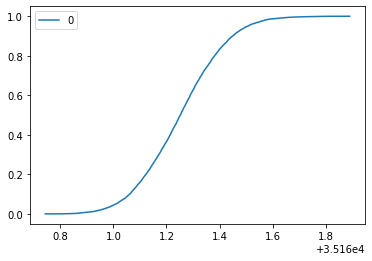

In [487]:
pd.DataFrame(y, index = x).plot()

In [441]:
V_30_rec = sample_V_rec(R1, years, sample_size,p, c, yearly_investment=1000)
print(f'Mean: {V_30_rec.mean()[0]}, 1% Quantile: {emp_quantile(0.01, V_30_rec)}')

Mean: 35161.24940382561, 1% Quantile: 35161.51825827211


In [442]:
r_bar = 0.005

V_30_TI = sample_V_TI(R1, years, sample_size, r_bar)
#V_30_TI.plot.hist(bins=50)
print(f'Mean: {V_30_TI.mean()[0]}, 1% Quantile: {emp_quantile(0.01, V_30_TI)}')

Mean: 36886.04525556673, 1% Quantile: 41980.43456569122


In [443]:
V_30_TI_rec = sample_V_TI_rec(R1, years, sample_size, r_bar)
#V_30_TI_rec.plot.hist(bins=50)
print(f'Mean: {V_30_TI_rec.mean()[0]}, 1% Quantile: {emp_quantile(0.01, V_30_TI_rec)}')

Mean: 36886.04525556668, 1% Quantile: 41980.43456569116


Mean: 42700.94941860083, Median: 33235.295454055915, 1% Quantile: 35642.81890841246


<AxesSubplot:ylabel='Frequency'>

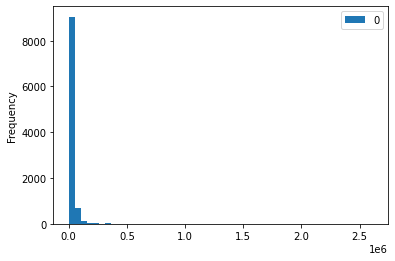

In [629]:
r_bar = 0.005
sample_lev = sample_V_lev(R1, years, sample_size, r_bar, leverage=3)
print(f'Mean: {sample_lev.mean()[0]}, Median: {sample_lev.median()[0]}, 1% Quantile: {emp_quantile(0.01, sample_lev)}')
sample_lev.plot.hist(bins=50)

In [630]:
data = yf.Ticker("SPY").history(period="MAX")
close = data['Close']
rets = close.pct_change(25) # montly return
rets = rets[25:] + 1

In [631]:
months = 12 #Month in 30 years
sample_size = int(1e7)
yearly_historical = pd.DataFrame(np.random.choice(rets.values, size=(sample_size, months), replace=True)).prod(axis=1)

In [632]:
sample_size = int(1e4)
years = 30
R1 = pd.DataFrame(np.random.choice(yearly_historical.values, size=(sample_size, years), replace=True))

In [635]:
dives = 3
high = 1
low = 0
for d in range(dives):
    V_30s = []
    params = np.random.uniform(high = high, low = low, size=(10000,2))
    for p,c in params:    
        V_30 = sample_V(R1, years, sample_size,p, c, yearly_investment=1000)
        mean = V_30.mean()
        var = V_30.var()
        V_30s.append((mean - 0.5*var)[0])
        #V_30.plot.hist(bins=50)
    V_30s = pd.DataFrame(V_30s)
    high = params[V_30s.sort_values(by=0).index[-10:]].max(axis=0)
    low = params[V_30s.sort_values(by=0).index[-10:]].min(axis=0)

Mean: 35173.99525042523, Median: 0    35173.932857
dtype: float64, 1% Quantile: 35173.55000902971


<AxesSubplot:ylabel='Frequency'>

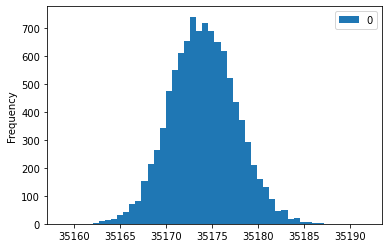

In [636]:
p, c = params[V_30s.sort_values(by=0).index[-1:]][0]
V_30 = sample_V(R1, years, sample_size, p, c, yearly_investment=1000)
print(f'Mean: {V_30.mean()[0]}, Median: {V_30.median()}, 1% Quantile: {emp_quantile(0.01, V_30)}')
V_30.plot.hist(bins=50)

Mean: 49162.617527543756, 1% Quantile: 57630.652510335436


<AxesSubplot:ylabel='Frequency'>

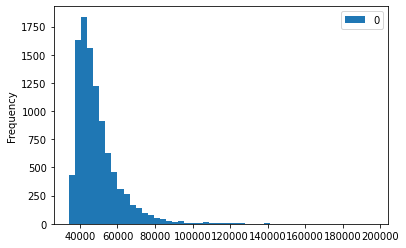

In [619]:
V_30_TI = sample_V_TI(R1, years, sample_size, r_bar)
print(f'Mean: {V_30_TI.mean()[0]}, 1% Quantile: {emp_quantile(0.01, V_30_TI)}')
V_30_TI.plot.hist(bins=50)

Mean: 1910218.6815279613, Median: 181850.29781548798, 1% Quantile: 2159392.3914305475


<AxesSubplot:ylabel='Frequency'>

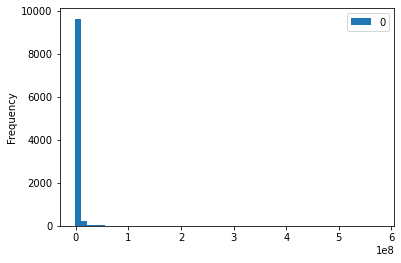

In [626]:
sample_lev = sample_V_lev(R1, years, sample_size, r_bar, leverage=3)
print(f'Mean: {sample_lev.mean()[0]}, Median: {sample_lev.median()[0]}, 1% Quantile: {emp_quantile(0.01, sample_lev)}')
sample_lev.plot.hist(bins=50)